In [1]:
from __future__ import print_function

# Standard modules
import os
import pickle
import numpy as np
import nibabel as nib

# Dipy modules
import dipy.viz.regtools as rt
import dipy.align.imwarp as imwarp
from dipy.align import VerbosityLevels
from dipy.align.imaffine import MutualInformationMetric, AffineRegistration
from dipy.align.transforms import regtransforms

# EPI correction (new) modules
import dipy.correct.gradients as gr
from dipy.correct.splines import CubicSplineField
from dipy.correct.epicor import (OppositeBlips_CC,
                                 OffResonanceFieldEstimator)
%pylab inline
pylab.rcParams['figure.figsize'] = (14, 10)
floating = np.float64

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load data
data_dir = '/home/omar/data/topup_example/'
up_fname = data_dir + "b0_blipup.nii"
down_fname = data_dir + "b0_blipdown.nii"

up_nib = nib.load(up_fname)
up_affine = up_nib.get_affine()
direction, spacings = imwarp.get_direction_and_spacings(up_affine, 3)
up = up_nib.get_data().squeeze().astype(np.float64)

down_nib = nib.load(down_fname)
down_affine = down_nib.get_affine()
down = down_nib.get_data().squeeze().astype(np.float64)

In [3]:
# Parameters
radius = 4
level_iters = [200, 200, 200, 200, 200, 200, 200, 200, 200]
lambdas = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
                   0.5, 0.05, 0.05])*300
fwhm = np.array([8, 6, 4, 3, 3, 2, 1, 0, 0])

pedir_up = np.array((0,1,0), dtype=np.float64)
pedir_down = np.array((0,-1,0), dtype=np.float64)

# Preprocess intensities
up /= up.mean()
down /= down.mean()

# Configure and run orfield estimation
distortion_model = OppositeBlips_CC(radius=radius)
estimator = OffResonanceFieldEstimator(distortion_model, level_iters=level_iters, lambdas=lambdas, fwhm=fwhm)

In [4]:
# Optimize or load results
orfield_coef_fname = 'orfield_coef_new_ss.p'
if os.path.isfile(orfield_coef_fname):
    coef = pickle.load(open(orfield_coef_fname, 'r'))
    kspacing = np.round(estimator.warp_res[-1]/spacings)
    kspacing = kspacing.astype(np.int32)
    kspacing[kspacing < 1] = 1
    orfield = CubicSplineField(up.shape, kspacing)
    orfield.copy_coefficients(coef)
else:
    orfield = estimator.optimize_with_ss(down, down_affine, pedir_down, up, up_affine, pedir_up, spacings)
    pickle.dump(np.array(orfield.coef), open(orfield_coef_fname, 'w'))

Stage: 1 / 9
('>>>kspacing:', array([6, 6, 6], dtype=int32))
('>>>resampled_sp:', array([ 3.59375   ,  3.59375024,  3.60000014]))
Creating field
Iter: 1 / 200
Energy: 0.367674. [inf]
Iter: 2 / 200
Energy: 0.362141. [inf]
Iter: 3 / 200
Energy: 0.356548. [inf]
Iter: 4 / 200
Energy: 0.350898. [inf]
Iter: 5 / 200
Energy: 0.345185. [inf]
Iter: 6 / 200
Energy: 0.339224. [inf]
Iter: 7 / 200
Energy: 0.333109. [inf]
Iter: 8 / 200
Energy: 0.326959. [inf]
Iter: 9 / 200
Energy: 0.321025. [inf]
Iter: 10 / 200
Energy: 0.315457. [inf]
Iter: 11 / 200
Energy: 0.310253. [inf]
Iter: 12 / 200
Energy: 0.305394. [0.001427]
Iter: 13 / 200
Energy: 0.300857. [0.001423]
Iter: 14 / 200
Energy: 0.296614. [0.001405]
Iter: 15 / 200
Energy: 0.292670. [0.001373]
Iter: 16 / 200
Energy: 0.288927. [0.001329]
Iter: 17 / 200
Energy: 0.285333. [0.001278]
Iter: 18 / 200
Energy: 0.281926. [0.001223]
Iter: 19 / 200
Energy: 0.278755. [0.001167]
Iter: 20 / 200
Energy: 0.275772. [0.001113]
Iter: 21 / 200
Energy: 0.272966. [0.001

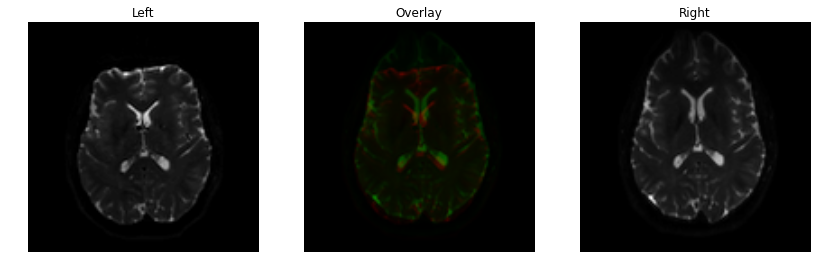

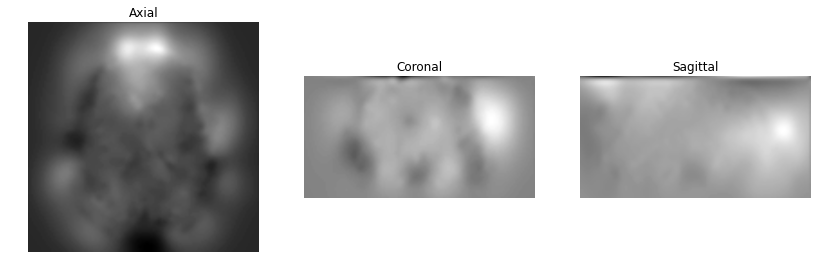

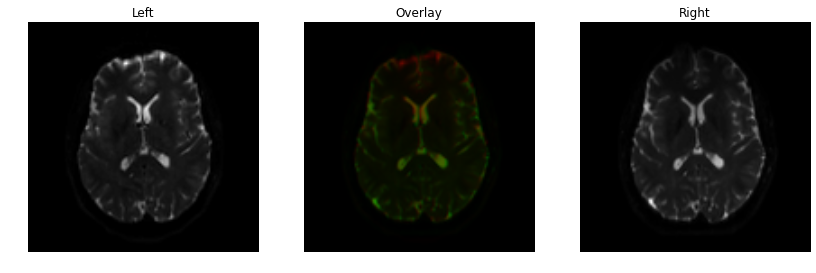

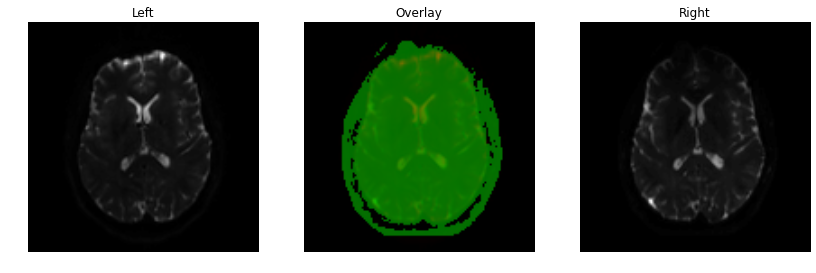

In [6]:
# Warp and modulte images
b  = np.array(orfield.get_volume((0, 0, 0)))
db = np.array(orfield.get_volume((0, 1, 0)))
shape = np.array(up.shape, dtype=np.int32)
w_up, _m = gr.warp_with_orfield(up, b, pedir_up, None,
                                None, None, shape)
w_down, _m = gr.warp_with_orfield(down, b, pedir_down, None,
                                  None, None, shape)
rt.overlay_slices(down, up, slice_type=2);
rt.plot_slices(b);
rt.overlay_slices(w_down, w_up, slice_type=2);
rt.overlay_slices(w_down*(1.0+db), w_up*(1-db), slice_type=2);